In [2]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import logging
import pandas as pd
import pandahouse
import os
import datetime as dt

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220220'
}

In [3]:
chat_id = 1295860693
bot = telegram.Bot(token='5291500178:AAFQqAVPSG4ad90QdyE-IaZH-Ai8ow2oxFs')
#bot = telegram.Bot(token=os.environ.get("report_bot_token"))
# для удобства построения графиков в запрос можно добавить колонки date, hm
q =  ''' select 
                        Full_time, date, Hour_min,
                        sum(activ_feed_users) as activ_feed_users,
                        sum(likes) as likes,
                        sum(views) as views,
                        sum(activ_mess_users) as activ_mess_users,
                        sum(messages) as messages

                    from
                        (select 
                            all_unique_users.Full_time as Full_time ,
                            all_unique_users.date as date,
                            all_unique_users.Hour_min as Hour_min,
                            feed_table.activ_feed_users as activ_feed_users,
                            feed_table.likes as likes,
                            feed_table.views as views,
                            likes*100/views as CTR,
                            mess_table.activ_mess_users AS activ_mess_users,
                            mess_table.messages as messages
                        from
                            (Select 
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id
                            from simulator_20220220.feed_actions
                            group by Full_time, date, Hour_min, user_id
                            union all
                            Select 
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id
                            from simulator_20220220.message_actions
                            group  by Full_time, date, Hour_min, user_id) as all_unique_users
                        left join
                            (select
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id,
                                count(distinct user_id) as activ_feed_users,
                                countIf(user_id, action = 'like') as likes,
                                countIf(user_id, action = 'view') as views
                            from simulator_20220220.feed_actions
                            group by Full_time, date, Hour_min, user_id) as feed_table 
                        on all_unique_users.user_id = feed_table.user_id and all_unique_users.Full_time = feed_table.Full_time
                        left join
                            (select
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id,
                                count(distinct user_id) as activ_mess_users,
                                count(user_id) as messages
                            from simulator_20220220.message_actions
                            group by Full_time, date, Hour_min, user_id) as mess_table
                        on all_unique_users.user_id = mess_table.user_id and all_unique_users.Full_time = mess_table.Full_time
                        where Full_time >=  today() - 1 and Full_time < toStartOfFifteenMinutes(now()) ) as virtual_table
                    group by Full_time, date, Hour_min
                    order by Full_time '''
df_allert = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df_allert['CTR'] = round(df_allert.likes*100/df_allert.views,2)

In [17]:
df_allert['CTR'].iloc[-1]

20.97

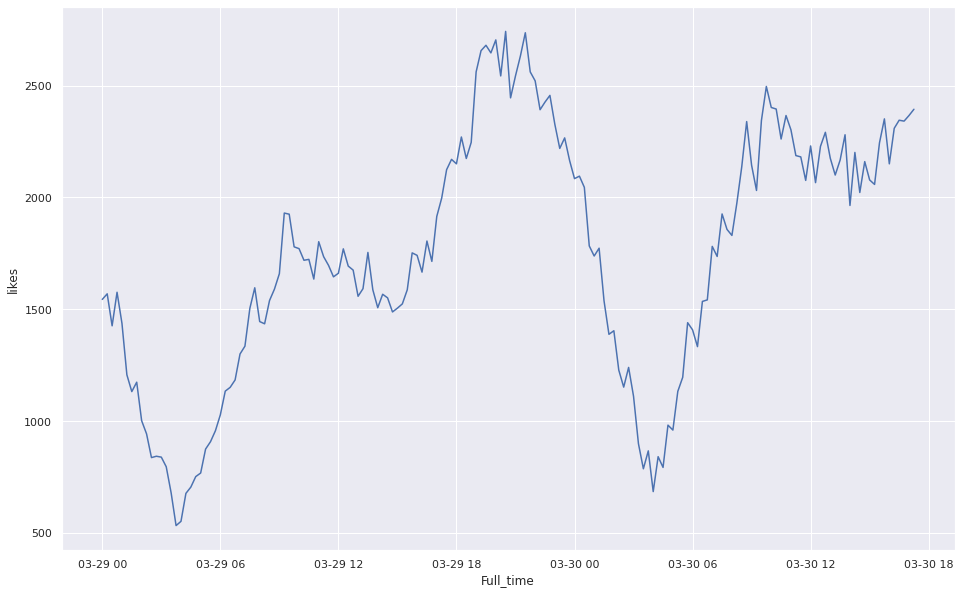

In [24]:
sns.set(rc={'figure.figsize': (16, 10)}) # задаем размер графика
plt.tight_layout()

ax = sns.lineplot(data = df_allert, x = 'Full_time', y = 'likes', label = 'metric')

In [35]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import logging
import pandas as pd
import pandahouse
import os
import datetime as dt

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220220'
}


def check_anomaly(df_metric, metric, a=3.5, n=4):
    # функция check_anomaly предлагает алгоритм проверки значения на аномальность посредством
    # межквартильного размаха  IQR
    # shift(1) - сдвигаем массив на 1 вперед, в итоге рассчет ведется не включая последнего значения (оно мб дефектным)
    df_metric['q25'] = df_metric[metric].shift(1).rolling(n).quantile(0.25)
    df_metric['q75'] = df_metric[metric].shift(1).rolling(n).quantile(0.75)
    df_metric['IQR'] = df_metric['q75'] - df_metric['q25']
    df_metric['up_border'] = df_metric['q25']-a*df_metric['IQR']
    df_metric['low_border'] = df_metric['q75']+a*df_metric['IQR']

    df_metric['up_border'] = df_metric['up_border'].rolling(n, center=True, min_periods=1).mean()
    df_metric['low_border'] = df_metric['low_border'].rolling(n, center=True, min_periods=1).mean()

    # проверяем больше ли отклонение метрики заданного порога threshold
    # если отклонение больше, то вернем 1, в противном случае 0
    if df_metric[metric].iloc[-1] > df_metric['up_border'].iloc[-1] or df_metric[metric].iloc[-1] < df_metric['low_border'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0

    return is_alert, df_metric


def run_alerts(chat=None):
    chat_id = chat or 1295860693
    bot = telegram.Bot(token='5291500178:AAFQqAVPSG4ad90QdyE-IaZH-Ai8ow2oxFs')
    #bot = telegram.Bot(token=os.environ.get("report_bot_token"))
    # для удобства построения графиков в запрос можно добавить колонки date, hm
    q = ''' select 
                        Full_time, date, Hour_min,
                        sum(activ_feed_users) as activ_feed_users,
                        sum(likes) as likes,
                        sum(views) as views,
                        sum(activ_mess_users) as activ_mess_users,
                        sum(messages) as messages

                    from
                        (select 
                            all_unique_users.Full_time as Full_time ,
                            all_unique_users.date as date,
                            all_unique_users.Hour_min as Hour_min,
                            feed_table.activ_feed_users as activ_feed_users,
                            feed_table.likes as likes,
                            feed_table.views as views,
                            likes*100/views as CTR,
                            mess_table.activ_mess_users AS activ_mess_users,
                            mess_table.messages as messages
                        from
                            (Select 
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id
                            from simulator_20220220.feed_actions
                            group by Full_time, date, Hour_min, user_id
                            union all
                            Select 
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id
                            from simulator_20220220.message_actions
                            group  by Full_time, date, Hour_min, user_id) as all_unique_users
                        left join
                            (select
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id,
                                count(distinct user_id) as activ_feed_users,
                                countIf(user_id, action = 'like') as likes,
                                countIf(user_id, action = 'view') as views
                            from simulator_20220220.feed_actions
                            group by Full_time, date, Hour_min, user_id) as feed_table 
                        on all_unique_users.user_id = feed_table.user_id and all_unique_users.Full_time = feed_table.Full_time
                        left join
                            (select
                                toStartOfFifteenMinutes(time) as Full_time,
                                toDate(Full_time) as date,
                                formatDateTime(Full_time, '%R') as Hour_min,
                                user_id,
                                count(distinct user_id) as activ_mess_users,
                                count(user_id) as messages
                            from simulator_20220220.message_actions
                            group by Full_time, date, Hour_min, user_id) as mess_table
                        on all_unique_users.user_id = mess_table.user_id and all_unique_users.Full_time = mess_table.Full_time
                        where Full_time >=  today() - 1 and Full_time < toStartOfFifteenMinutes(now()) ) as virtual_table
                    group by Full_time, date, Hour_min
                    order by Full_time '''
    df_allert = pandahouse.read_clickhouse(q, connection=connection)
    df_allert['CTR'] = round(df_allert.likes*100/df_allert.views, 2)

    for metric in df_allert.iloc[:, 3:].columns:
        df_metric = df_allert[['Full_time', 'date', 'Hour_min', metric]].copy()
        # проверяем метрику на аномальность алгоритмом, описаным внутри функции check_anomaly()
        is_alert, df_metric = check_anomaly(df_metric, metric)

        if is_alert:
            msg = '''Метрика {metric}:\nтекущее значение = {current_value:.2f}\nотклонение от вчера {diff:.2%}'''\
                .format(metric=metric, 
                        current_value=df_metric[metric].iloc[-1], 
                        diff=1-df_metric[metric].iloc[-1]/df_metric[metric].iloc[-2])

            sns.set(rc={'figure.figsize': (16, 10)})  # задаем размер графика
            plt.tight_layout()

            ax = sns.lineplot(data=df_metric, x='Full_time',
                              y=metric, label='metric')
            ax = sns.lineplot(data=df_metric, x='Full_time',
                              y='up_border', label='up_border')
            ax = sns.lineplot(data=df_metric, x='Full_time',
                              y='low_border', label='low_border')

            # этот цикл нужен чтобы разрядить подписи координат по оси Х,
            for ind, label in enumerate(ax.get_xticklabels()):
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
            ax.set(xlabel='time')  # задаем имя оси Х
            ax.set(ylabel=metric)  # задаем имя оси У

            ax.set_title('{}'.format(metric))  # задае заголовок графика
            ax.set(ylim=(0, None))  # задаем лимит для оси У

            # формируем файловый объект
            plot_object = io.BytesIO()
            ax.figure.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = '{0}.png'.format(metric)
            plt.close()

            # отправляем алерт
            bot.sendMessage(chat_id=chat_id, text=msg)
            bot.sendPhoto(chat_id=chat_id, photo=plot_object)


try:
    run_alerts()
except Exception as e:
    print(e)
